# Preprocessing

TODO: 
- execute the loops on test audio and test labels (colab?)

## training examples (audio)
- load audio
- perform cqt transform
- add some frequency bins to match 128 frequency bins of MIDI standard
- save the resulting matrix (cqt spectrogram)

## training labels (csv)
- load note data
- convert to seconds
- convert into indicator vector (128 lines x N columns, lines are notes, columns are time intevals, 1 and 0 to represent not being played or not) (same as defined for audio sequences)

# Processing audio
## Computing and saving CQT for each audio file

In [59]:
import os
import gc
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm

train_audio_dir = 'datasets/musicnet/musicnet/train_data'
train_cqt_dir = 'datasets/musicnet/musicnet/train_cqt/'

if not os.path.exists(train_cqt_dir):
    os.makedirs(train_cqt_dir)

LIMIT = 1000 # limit on number of files to load
count = 0
n_of_files_already_processed = len([name for name in os.listdir(train_cqt_dir) if os.path.isfile(os.path.join(train_cqt_dir, name))])
files_to_process = os.listdir(train_audio_dir)[n_of_files_already_processed:]

# loop over audio files in the training set
for filename in tqdm(files_to_process, total=len(files_to_process)):
    if count >= LIMIT:
        break
    else:
        # get the audio
        filepath = os.path.join(train_audio_dir, filename)
        audio_data, sr = librosa.load(filepath, sr=None)

        # perform ConstantQ transform
        # midi standard goes from C0 to F#10 for 128 pitch total
        C0_freq = 16.35	# starting frequency
        sr = 44100      # Sampling rate
        TIMESTEP = 0.10 # Desired TIMESTEP in seconds
        # Calculate the number of samples for the desired TIMESTEP
        hop_length = int(sr * TIMESTEP)
        cqt_data = librosa.cqt(audio_data, fmin=C0_freq, n_bins=125, sr=sr, hop_length=hop_length)

        # CQT can't compute above 125 frequency bins so will add lines of 0s manually
        # so we'll 3 add rows to match 128 frequency bins to match the MIDI file standard
        zeros = np.zeros((3, cqt_data.shape[1]))
        cqt_data = np.vstack((cqt_data, zeros))

        # Trying things for memory
        # Clear variables no longer needed
        del audio_data
        gc.collect()  # Perform garbage collection

        # save the cqt array
        np.save(train_cqt_dir + filename.split('.')[0], cqt_data)
        count += 1

        # Clear variables and perform garbage collection
        del cqt_data
        gc.collect()

['1727.npy', '1728.npy', '1729.npy', '1730.npy', '1733.npy', '1734.npy', '1735.npy', '1739.npy', '1742.npy', '1749.npy', '1750.npy', '1751.npy', '1752.npy', '1755.npy', '1756.npy', '1757.npy', '1758.npy', '1760.npy', '1763.npy', '1765.npy', '1766.npy', '1768.npy', '1771.npy', '1772.npy', '1773.npy', '1775.npy', '1776.npy', '1777.npy', '1788.npy', '1789.npy', '1790.npy', '1791.npy', '1792.npy', '1793.npy', '1805.npy', '1807.npy', '1811.npy', '1812.npy', '2374.npy', '2376.npy', '2377.npy', '2379.npy', '2381.npy', '2383.npy', '2384.npy', '2388.npy', '2389.npy', '2390.npy', '2391.npy', '2392.npy', '2393.npy', '2397.npy', '2398.npy', '2403.npy', '2404.npy', '2405.npy', '2406.npy', '2506.npy', '2507.npy', '2509.npy', '2510.npy', '2512.npy', '2514.npy', '2516.npy', '2521.npy', '2522.npy', '2523.npy', '2527.npy', '2528.npy', '2529.npy', '2530.npy', '2531.npy', '2532.npy', '2533.npy', '2537.npy', '2538.npy', '2198.npy', '2200.npy', '2201.npy', '2202.npy', '2203.npy', '2204.npy', '2207.npy', '22

## How to load the arrays

In [2]:
import os
import numpy as np

train_cqt_dir = 'datasets/musicnet/musicnet/train_cqt/'

# load the array
file = os.listdir(train_cqt_dir)[0]
filepath = train_cqt_dir + file
print(filepath)

cqt_array = np.array(np.load(filepath))
print(cqt_array)
print(cqt_array.shape) # freq_bins X time_intervals (one interval = 0.1s)

datasets/musicnet/musicnet/train_cqt/1727.npy
[[ 2.57428765e-04-2.22782124e-04j -5.93174540e-04-3.43217507e-05j
   5.20157162e-04+5.71272685e-04j ...  5.13322302e-05-6.84659483e-07j
  -5.35671388e-05-8.05060699e-06j  5.88376097e-05+4.16767107e-05j]
 [-2.69114738e-04+3.92691763e-05j -3.82055550e-05+6.25704299e-04j
   9.04196466e-04+1.21861180e-04j ... -6.72054157e-05+1.06477870e-04j
   7.02706820e-05+1.08719127e-04j  1.41021737e-04-3.36765697e-05j]
 [ 1.82399323e-04+4.40537144e-04j  8.38531647e-04+2.32781895e-04j
   1.03155267e-03-7.93580606e-04j ... -5.60147600e-05+2.10249462e-04j
   1.74279354e-04+1.81913929e-04j  2.47208431e-04-4.66376296e-05j]
 ...
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j ...  0.00000000e+00+0.00000000e+00j
 

## Very plot

/tmp/ipykernel_161564/3470641041.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(cqt_array[:,:len(cqt_array)//3], ref=np.max), sr=44100, hop_length=4410, x_axis='time', y_axis='cqt_note')
/tmp/ipykernel_161564/3470641041.py:5: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(librosa.amplitude_to_db(cqt_array[:,:len(cqt_array)//3], ref=np.max), sr=44100, hop_length=4410, x_axis='time', y_axis='cqt_note')


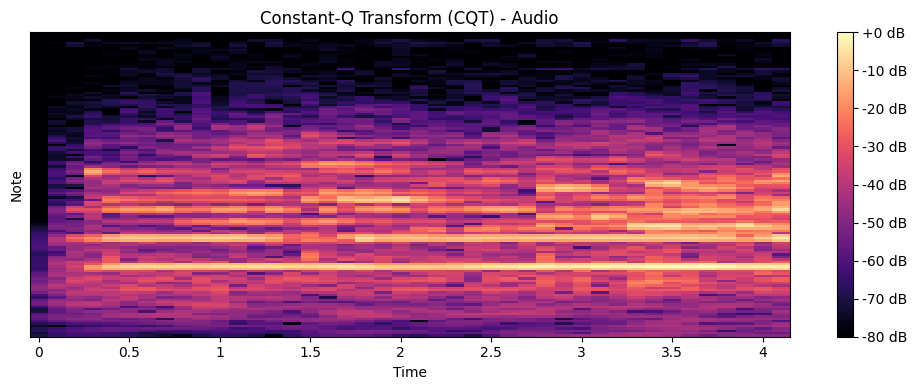

In [8]:
import matplotlib.pyplot as plt
import librosa

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(cqt_array[:,:len(cqt_array)//3], ref=np.max), sr=44100, hop_length=4410, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT) - Audio')
plt.tight_layout()
plt.show()

# Processing labels

## First testing things with one file then looping over all files

In [7]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("datasets/musicnet/musicnet/train_labels/1727.csv", delimiter=",")

# Convert times to seconds, i don't know what unit the times are, but i know
# the factor to get seconds by looking at metadata and labels and comparing
# duration of song and end_time of last note
df[['start_time', 'end_time']] /= 44100
# print(df)

# Extract the required columns: start_time, end_time, note
note_list = df[["start_time", "end_time", "note"]].values.tolist()

# Print the first few rows to verify the data
print(note_list[:5])

[[0.20820861678004535, 2.0425850340136056, 53.0], [0.20820861678004535, 0.7654875283446712, 65.0], [0.20820861678004535, 1.4156462585034013, 69.0], [0.20820861678004535, 4.585170068027211, 41.0], [0.20820861678004535, 1.4156462585034013, 81.0]]


In [9]:
def convert_to_matrix(notes, timestep):
    """
    Convert the note event to a matrix representing
    note activation at each timestep. One column represent
    1 time interval and will be filled with 1 or 0 on the line
    which corresponds to a note being active or not.

    notes: list of list containing these [note_start, note_end, note_pitch]
    timestep: in seconds
    """
    import sys
    # Find the total duration of the notes
    total_duration = max(note[1] for note in notes)
    
    # Calculate the number of timesteps(s)
    num_timesteps = int(total_duration / timestep) + 1

    # Create an empty matrix filled with zeros
    n_of_notes = 128 # as per the midi standard
    matrix = [[0] * num_timesteps for _ in range(n_of_notes)]
    
    # Populate the matrix with ones where notes are played
    for note in notes:
        # range where a note is active
        start_idx = int(note[0] / timestep)
        end_idx = int(note[1] / timestep)

        # fill in 1s for all the corresponding timesteps at the line
        # which corresponds to the pitch
        for timestep_idx in range(start_idx, end_idx + 1):
            pitch_idx = int(note[2])
            try:
                matrix[pitch_idx][timestep_idx] = 1
            except Exception as err:
                print(err)
                print(pitch_idx, timestep_idx)
                sys.exit()

    return matrix

TIMESTEP = 0.1
mat = convert_to_matrix(note_list, TIMESTEP)

In [12]:
print(np.array(mat).shape)

time_interval_number = 2
time_interval = [note_bin[time_interval_number] for note_bin in mat]
len(time_interval)
print([(i, val) for (i, val) in enumerate(time_interval) if val==1])

(128, 4404)
[(41, 1), (53, 1), (65, 1), (69, 1), (81, 1)]


## Testing is over now for the real loop

In [58]:
import os
import pandas as pd
from tqdm import tqdm

# Directory containing the CSV files
directory = "datasets/musicnet/musicnet/train_labels/"
out_directory = "datasets/musicnet/musicnet/train_labels_bettered/"

if not os.path.exists(out_directory):
    os.makedirs(out_directory)


# Loop over files in the directory
for filename in tqdm(os.listdir(directory), total=len(os.listdir(directory))):
    if filename.endswith(".csv"):
        # Load the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath, delimiter=",")
        print(filename)
        
        # Convert times to seconds, i don't know what unit the times are, but i know
        # the factor to get seconds by looking at metadata and labels and comparing
        # duration of song and end_time of last note
        df[['start_time', 'end_time']] /= 44100

        # Extract the required columns: start_time, end_time, note
        note_list = df[["start_time", "end_time", "note"]].values.tolist()

        # Print the first few rows to verify the data
        # print(note_list[:5])

        # process the note list to turn into a timestepped matrix
        mat = convert_to_matrix(note_list, TIMESTEP)

        # Save the resulting matrix in a CSV file with the same name
        output_filename = os.path.splitext(filename)[0] + ".csv"
        output_filepath = os.path.join(out_directory, output_filename)
        pd.DataFrame(mat).to_csv(output_filepath, index=False, mode='w')

['.~lock.1765.csv#', '1727.csv', '1728.csv', '1729.csv', '1730.csv', '1733.csv', '1734.csv', '1735.csv', '1739.csv', '2288.csv', '2289.csv', '2292.csv', '2293.csv', '2294.csv', '2295.csv', '2296.csv', '2297.csv', '2300.csv', '2482.csv', '2483.csv', '2486.csv', '2487.csv', '2488.csv', '2490.csv', '2491.csv', '2492.csv', '2494.csv', '2150.csv', '2151.csv', '2154.csv', '2155.csv', '2156.csv', '2157.csv', '2158.csv', '2159.csv', '2160.csv', '2161.csv', '2166.csv', '2167.csv', '2372.csv', '2373.csv', '2374.csv', '2376.csv', '2377.csv', '2379.csv', '2381.csv', '2383.csv', '2384.csv', '2388.csv', '2389.csv', '2390.csv', '2391.csv', '2392.csv', '2393.csv', '2397.csv', '2398.csv', '2403.csv', '2404.csv', '2405.csv', '2406.csv', '2410.csv', '2411.csv', '2415.csv', '2417.csv', '2420.csv', '1742.csv', '1763.csv', '1776.csv', '1811.csv', '1932.csv', '2149.csv', '2168.csv', '2210.csv', '2285.csv', '2302.csv', '2320.csv', '2371.csv', '2422.csv', '2481.csv', '2497.csv', '2521.csv', '2564.csv', '1812.c

## How to load the data

In [14]:
# load one file of labels
df = pd.read_csv("datasets/musicnet/musicnet/train_labels_bettered/1727.csv", delimiter=",")
print(df)

# print note pitch being played at a certain time interval
matrix_list = df.values.tolist()
interval_number = 2
# take a column of the matrix which correspond to a certain time interval
time_interval = [note_bin[interval_number] for note_bin in matrix_list]
print([(i, val) for (i, val) in enumerate(time_interval) if val==1])

     0  1  2  3  4  5  6  7  8  9  ...  4394  4395  4396  4397  4398  4399  \
0    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
..  .. .. .. .. .. .. .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   
123  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
124  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
125  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
126  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
127  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

     4400  4401  4402  4403  
0       0     0     0     0  
1  

# Make the columns of cqt data and labelled data match

In [4]:
import os 
from tqdm import tqdm
import numpy as np

train_cqt_dir = 'datasets/musicnet/musicnet/train_cqt/'

all_cqt_matrices = []
cqt_files_to_load = sorted(os.listdir(train_cqt_dir))

for file in tqdm(cqt_files_to_load, total=len(os.listdir(train_cqt_dir))):
    cqt_mat = np.array(np.load(train_cqt_dir + file))
    all_cqt_matrices.append(cqt_mat)


100%|██████████| 320/320 [00:05<00:00, 63.44it/s] 


In [61]:
print(all_cqt_matrices[0].shape, len(all_cqt_matrices))

(128, 4471) 320


In [13]:
import pandas as pd

train_labeldir = "datasets/musicnet/musicnet/train_labels_bettered/"

all_label_mats =  []
label_files_to_load = sorted(os.listdir(train_labeldir))

for file in tqdm(label_files_to_load, total=len(os.listdir(train_labeldir))):
    df = pd.read_csv(train_labeldir + file, delimiter=",")
    matrix_list = np.array(df.values.tolist())
    all_label_mats.append(matrix_list)


100%|██████████| 320/320 [00:56<00:00,  5.68it/s]


In [14]:
print(all_label_mats[0].shape, len(all_label_mats))

(128, 4404) 320


In [15]:
def check_shape_match(all_cqt_matrices, all_label_mats):
    for i in range(len(all_cqt_matrices)):
        cqt_mat, label_mat = all_cqt_matrices[i], all_label_mats[i]
        if cqt_mat.shape != label_mat.shape:
            print(i, cqt_mat.shape, label_mat.shape)

In [16]:
check_shape_match(all_cqt_matrices, all_label_mats)

0 (128, 4471) (128, 4404)
1 (128, 2512) (128, 2468)
2 (128, 4445) (128, 4406)
3 (128, 3686) (128, 3562)
4 (128, 5461) (128, 5436)
5 (128, 3257) (128, 3211)
6 (128, 7150) (128, 7104)
7 (128, 4905) (128, 4893)
8 (128, 9246) (128, 9204)
9 (128, 6964) (128, 6894)
10 (128, 7842) (128, 7786)
11 (128, 4757) (128, 4694)
12 (128, 3628) (128, 3555)
13 (128, 2298) (128, 2254)
14 (128, 3715) (128, 3681)
15 (128, 7107) (128, 7073)
16 (128, 4685) (128, 4626)
17 (128, 6556) (128, 6509)
18 (128, 6004) (128, 5827)
19 (128, 4383) (128, 4314)
20 (128, 6766) (128, 6724)
21 (128, 4274) (128, 4243)
22 (128, 2909) (128, 2817)
23 (128, 6474) (128, 6423)
24 (128, 4175) (128, 4074)
25 (128, 3074) (128, 3041)
26 (128, 5783) (128, 5720)
27 (128, 7261) (128, 7179)
28 (128, 6295) (128, 6241)
29 (128, 5132) (128, 5100)
30 (128, 4614) (128, 4586)
31 (128, 3239) (128, 3193)
32 (128, 3516) (128, 3490)
33 (128, 4728) (128, 4671)
34 (128, 5049) (128, 4998)
35 (128, 3568) (128, 3536)
36 (128, 4445) (128, 4400)
37 (128, 48

In [17]:
all_label_mats_padded = []
for i in tqdm(range(len(all_cqt_matrices)), total = len(all_cqt_matrices)):
    cqt_mat, label_mat = all_cqt_matrices[i], all_label_mats[i]

    diff_columns = cqt_mat.shape[1] - label_mat.shape[1]

    # everything SHOULD be positive
    if diff_columns > 0:
        zeros_to_add = np.zeros((label_mat.shape[0], diff_columns))
        label_mat = np.concatenate((label_mat, zeros_to_add), axis=1)
    else:
        print(i, cqt_mat.shape, label_mat.shape)

    all_label_mats_padded.append(label_mat)

 23%|██▎       | 75/320 [00:00<00:01, 239.06it/s]

46 (128, 2369) (128, 2369)


 52%|█████▏    | 167/320 [00:00<00:00, 350.42it/s]

143 (128, 1940) (128, 1940)
172 (128, 6460) (128, 6460)


 82%|████████▎ | 264/320 [00:01<00:00, 235.09it/s]

236 (128, 3353) (128, 3353)


100%|██████████| 320/320 [00:01<00:00, 232.68it/s]

298 (128, 5129) (128, 5129)


In [18]:
check_shape_match(all_cqt_matrices, all_label_mats_padded)

None


# Concat everything into 128 x N for both matrices, transpose and save

In [9]:
import numpy as np
from tqdm import tqdm

print([all_cqt_matrices[i].shape for i in range(5)])

all_cqt_concatenated = np.transpose(np.concatenate(all_cqt_matrices, axis=1))

[(128, 4471), (128, 2512), (128, 4445), (128, 3686), (128, 5461)]


0

In [10]:
print(all_cqt_concatenated.shape)

(1214040, 128)


In [11]:
musicnet_dir = 'datasets/musicnet/musicnet/'
np.save(musicnet_dir + 'all_cqt_concatenated', all_cqt_concatenated)

In [19]:
print([all_label_mats_padded[i].shape for i in range(5)])

all_label_mats_padded_concatenated = np.transpose(np.concatenate(all_label_mats_padded, axis=1))

[(128, 4471), (128, 2512), (128, 4445), (128, 3686), (128, 5461)]


In [20]:
print(all_label_mats_padded_concatenated.shape)

(1214040, 128)


# Exploring the newly created all_cqt_concatenated.npy spectrum

In [39]:
import numpy as np
CQT = np.load("datasets/musicnet/musicnet/all_cqt_concatenated.npy")
CQT.shape

(1214040, 128)

(128, 15000)


/tmp/ipykernel_14350/2311559549.py:9: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(CQT_cropped, ref=np.max), sr=44100, hop_length=44100 * 0.1, x_axis='time', y_axis='cqt_note')
/tmp/ipykernel_14350/2311559549.py:9: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(librosa.amplitude_to_db(CQT_cropped, ref=np.max), sr=44100, hop_length=44100 * 0.1, x_axis='time', y_axis='cqt_note')


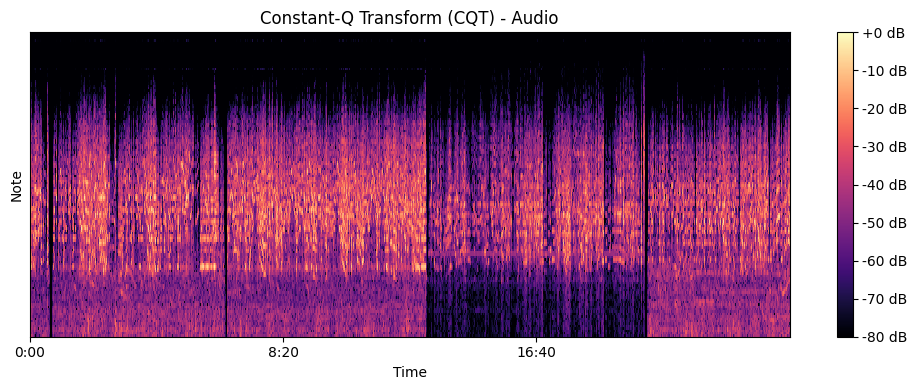

In [52]:
import matplotlib.pyplot as plt
import librosa

crop_start = 1_100_000
CQT_cropped = np.transpose(CQT[crop_start:crop_start + 15_000,:])
print(CQT_cropped.shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(CQT_cropped, ref=np.max), sr=44100, hop_length=44100 * 0.1, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT) - Audio')
plt.tight_layout()
plt.show()

# For later reconverting (frequency X time_interval) matrix back to a [note_start, note_end, note_pitch] matrix, from which we can generate a midi easily (midi_from_note_matrix.py)

In [55]:
def convert_to_notes(matrix, timestep):
    notes = []

    # Iterate through each row (note pitch) in the matrix
    for pitch_idx, pitch_row in enumerate(matrix):
        start_time = None

        # Iterate through each column (timestep) in the row
        for timestep_idx, value in enumerate(pitch_row):
            # if note is playing
            if value == 1:
                # Record the start time if not already set
                if start_time is None:
                    start_time = timestep_idx * timestep

                # if we're at the end of the row record the note
                if (timestep_idx + 1) == len(pitch_row):
                    end_time = (timestep_idx + 1) * timestep
                    pitch = pitch_idx
                    notes.append([round(start_time, 2), round(end_time, 2), pitch])
                    start_time = None

            # if we have a start_time AND value was not 1 (so 0) then record the note
            elif start_time is not None:
                end_time = timestep_idx * timestep
                pitch = pitch_idx
                notes.append([round(start_time, 2), round(end_time, 2), pitch])
                start_time = None

    # sort by start time
    sorted_notes = sorted(notes, key=lambda x: x[0])       
    return sorted_notes

# Example usage:
# rows are frequency bins (notes), and columns are time intervals
matrix = [[1, 1, 0, 1, 1],
          [0, 1, 1, 0, 1],
          [1, 0, 0, 1, 0]]

timestep = 0.1

result_notes = convert_to_notes(matrix, timestep)

# Print the resulting list of notes
print('note_start, note_end, note_pitch_idx\n\
(times are in seconds pitch index refers to the MIDI standard)')
for note in result_notes:
    print(note)

note_start, note_end, note_pitch_idx
(times are in seconds pitch index refers to the MIDI standard)
[0.0, 0.2, 0]
[0.0, 0.1, 2]
[0.1, 0.3, 1]
[0.3, 0.5, 0]
[0.3, 0.4, 2]
[0.4, 0.5, 1]
